<a href="https://colab.research.google.com/github/RiseAboveAll/PYTORCH_Learning/blob/master/Image_Recognition_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset 

MNIST Dataset

- Dataset of handwritten digits

- It is a multiclassification problem , it has 10 classes digits between 0-9, hence output activation function is softmax

-  Image size is 28x28 Hence input should have 784 neurons 

-  Model Architecture : Input -> Hiddel Layer1 -> Hidden Layer2 -> Output





## Train & Test Dataset

**To avoid overfitting:**

-  Reduce the Depth & Complexity of model

-  Reduce number of neurons in hidden layer

-  Reduce number of Epochs



## Image Transformation


In [34]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import functional as F
import requests
from PIL import Image
import PIL

In [35]:
#transforms.Normalize(mean,std)
transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(),
                              transforms.Normalize((.5,),(.5,))
                              ])
training_dataset=datasets.MNIST(root='.',train=True,download=True,transform=transform)
training_loader=DataLoader(training_dataset,batch_size=100,shuffle=True)  

validation_dataset=datasets.MNIST(root='.',train=True,download=False,transform=transform)
validation_loader=DataLoader(validation_dataset,batch_size=100,shuffle=False)  


In [36]:
def im_convert(tensor):
  #tensor.clone() is used to make a copy of tensor
  image=tensor.clone().detach().numpy()
  print(image.shape)
  #Tensor shape is 1x28x28 , to plot image we need shape as 28x28x1
  image=image.transpose(1,2,0)
  image=image * np.array((.5,.5,.5))+np.array((.5,.5,.5))
  image=image.clip(0,1)
  return image


**When normalizing the images, make sure to write transforms.Normalize((0.5,), (0.5,))  , rather than what we had earlier, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) . Ultimately, this is done to ensure a single channel of (1, 28, 28), rather than (3, 28, 28).**

(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)
(1, 28, 28)


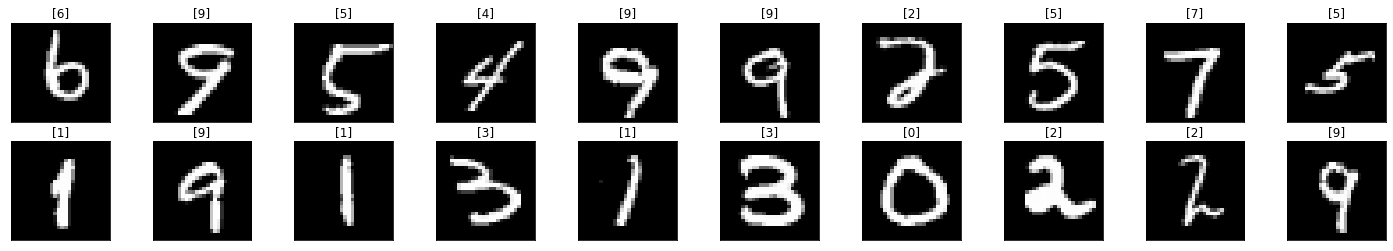

In [37]:
dataiter=iter(training_loader)
images,labels=dataiter.next()
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
  ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title([labels[i].item()])




## Model Building (Implementation)

In [38]:
class Classifier(nn.Module):
  def __init__(self,D_in, H1, H2, D_out):
    super().__init__()
    self.Linear1=nn.Linear(D_in,H1)
    self.Linear2=nn.Linear(H1,H2)
    self.Linear3=nn.Linear(H2,D_out)
  def forward(self,x):
    x=F.relu(self.Linear1(x))
    x=F.relu(self.Linear2(x))
    #Since this is the output layer we won't apply any activation function here
    x=self.Linear3(x) 
    return x 
  

In [39]:
model=Classifier(784,125,65,10)
model

Classifier(
  (Linear1): Linear(in_features=784, out_features=125, bias=True)
  (Linear2): Linear(in_features=125, out_features=65, bias=True)
  (Linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [40]:
#Need to use GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#transfers parameters of the model to the GPU
model.to(device)

cuda:0


Classifier(
  (Linear1): Linear(in_features=784, out_features=125, bias=True)
  (Linear2): Linear(in_features=125, out_features=65, bias=True)
  (Linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [41]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.0001)


In [42]:
epochs=12
running_loss_history=[]
val_running_loss_history=[]
running_correct_history=[]
val_running_correct_history=[]
for e in range(epochs):
  running_loss=0.0
  running_correct=0.0
  val_running_loss=0.0
  val_running_correct=0.0

  for images,labels in training_loader:
    images,labels=images.to(device),labels.to(device)
    images=images.view(images.shape[0],-1)
    outputs=model.forward(images)
    loss=criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _,preds=torch.max(outputs,1)
    
    running_loss += loss.item()
    running_correct += torch.sum(preds==labels.data)
  else:
    #to save memory use torch.no_grad()
    with torch.no_grad():
      for val_images,val_labels in validation_loader:
        val_images,val_labels=val_images.to(device),val_labels.to(device)
        val_images=val_images.view(val_images.shape[0],-1)
        val_outputs=model.forward(val_images)
        val_loss=criterion(val_outputs,val_labels)
        _,val_preds=torch.max(val_outputs,1)
        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_preds == val_labels.data)

    val_epoch_loss=val_running_loss/len(validation_loader)
    val_epoch_accuracy=val_running_correct.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_accuracy)
    epoch_loss=running_loss/len(training_loader)
    epoch_accuracy=running_correct.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_accuracy)
    print('training loss : {:.4f}, training accuracy : {:.4f}, validation loss : {:.4f} , validation accuracy : {:.4f}'.format(epoch_loss,epoch_accuracy.item(),val_epoch_loss,val_epoch_accuracy))


training loss : 0.9691, training accuracy : 76.5517, validation loss : 0.4377 , validation accuracy : 88.0650
training loss : 0.3776, training accuracy : 89.3650, validation loss : 0.3329 , validation accuracy : 90.5000
training loss : 0.3163, training accuracy : 90.8783, validation loss : 0.2947 , validation accuracy : 91.3900
training loss : 0.2825, training accuracy : 91.7867, validation loss : 0.2646 , validation accuracy : 92.3567
training loss : 0.2579, training accuracy : 92.5733, validation loss : 0.2432 , validation accuracy : 93.0833
training loss : 0.2368, training accuracy : 93.1900, validation loss : 0.2245 , validation accuracy : 93.4350
training loss : 0.2190, training accuracy : 93.7900, validation loss : 0.2051 , validation accuracy : 94.1600
training loss : 0.2029, training accuracy : 94.2167, validation loss : 0.1911 , validation accuracy : 94.5250
training loss : 0.1887, training accuracy : 94.5983, validation loss : 0.1787 , validation accuracy : 94.8667
training l

**We can see accuracy saturated at 95% and loss is at .1522**

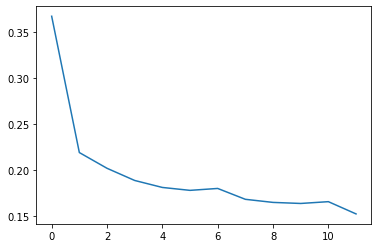

In [39]:
#At learning rate =.01
plt.plot(running_loss_history,label='training loss')

**We can see that the loss is fluctuating as epochs progresses. Recalling the concept of gradient descent, it gradually adjust the parameters of your model in the direction of the least error,descending with the gradient. The steps that it takes to arrive at optimal parameters is dictated by the learning rate. If learning rate is too high, the steps it take will be too large, such that the parameters will in a way flip flop back and forth between points overshooting the minimum and thus leading to divergent losses. As we see in this case. Decreasing the learning rate allows the model to better zero in on a solution for the parameters. When you see divergent losses you should decrease the learning rate**

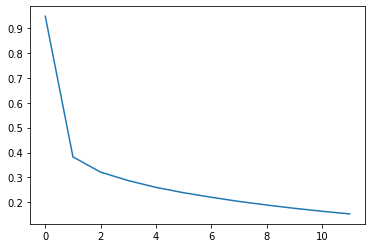

In [10]:
#At learning rate =.0001
plt.plot(running_loss_history,label='training loss')

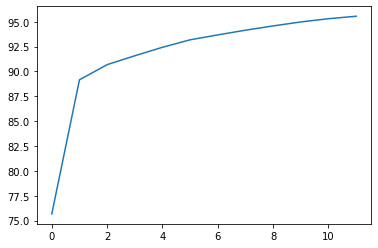

In [12]:
plt.plot(running_correct_history,label='Training Acc.')

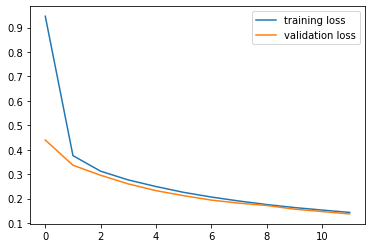

In [10]:
#At learning rate =.0001
plt.plot(running_loss_history,label='training loss')
#At learning rate =.0001
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

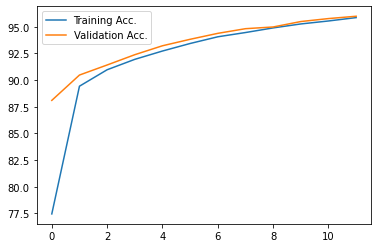

In [11]:
plt.plot(running_correct_history,label='Training Acc.')
plt.plot(val_running_correct_history,label='Validation Acc.')
plt.legend()

In [43]:
#Testing Link
url='https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'


(1, 28, 28)


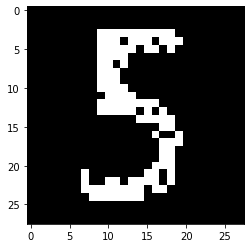

In [45]:
response=requests.get(url,stream=True)
img=Image.open(response.raw)
img=PIL.ImageOps.invert(img)
img=img.convert('1')
img=transform(img)
#img=img.clone().detach().numpy()
#img=img.transpose(1,2,0)


plt.imshow(im_convert(img))
img=img.to(device)

In [46]:
img=img.view(img.shape[0],-1)
output=model(img)
_,pred=torch.max(output,1)
print(pred.item())

5
